In [1]:
import torch 
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt 

from data import Data, squiggle
from modules import MLP

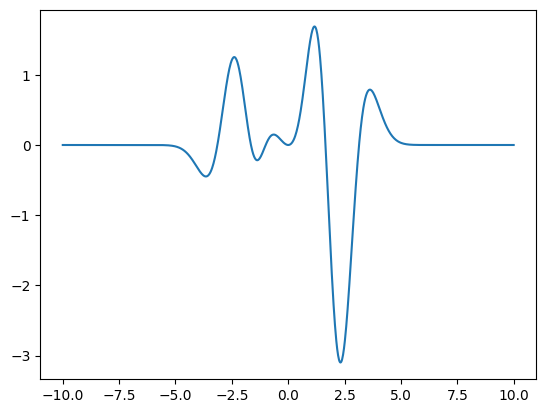

In [2]:
x = np.linspace(-10,10,1000)
plt.plot(x, squiggle(x))
plt.show()

In [57]:
class BinnedRegressionModel(nn.Module):
  def __init__(self, bin_edges, low, high, dropout=0.05, hidden_size=128, num_layers=2):
    super().__init__()
    self.bin_edges = bin_edges
    self.bin_centers = torch.zeros(len(bin_edges)+1)
    self.bin_centers[1:-1] = (bin_edges[1:] + bin_edges[:-1])/2
    self.bin_centers[0], self.bin_centers[-1] = low, high
    self.model = MLP(hidden_size=hidden_size, dropout=dropout, num_layers=num_layers, num_outputs=len(bin_edges)+1)
    
  def forward(self, x):
    return self.model(x)

  def forward_regress_entropy(self, x):
    logits = self(x)
    log_prob = F.log_softmax(logits, dim=-1)
    entropy = - (log_prob * torch.exp(log_prob)).mean(axis=-1)
    regression = self.bin_centers[logits.argmax(axis=1)]
    return regression, entropy
  
  def compute_loss(self, x, y):
    logits = self.forward(x)
    with torch.no_grad():
      y_binned = torch.bucketize(y, self.bin_edges)
    return F.cross_entropy(logits, y_binned.view(-1)).mean()

In [61]:
dl_train = DataLoader(Data(squiggle, low=-4, high=4, seed=1, sigma=.1), batch_size=32, shuffle=True, drop_last=True)
dl_val = DataLoader(Data(squiggle,  low=-4, high=4, seed=2, sigma=.1), batch_size=32, shuffle=True, drop_last=True)

bin_edges = torch.linspace(-4,4,40)
model = BinnedRegressionModel(bin_edges=bin_edges, low=-4, high=4)
optimizer = torch.optim.AdamW(model.parameters(), lr=6e-4, weight_decay=1e-2)

In [62]:
for epoch in range(500):
  model.train()
  train_loss = []
  for batch in dl_train:
    x, y = batch
    loss = model.compute_loss(x, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss.append(loss.item())
  model.eval()
  val_loss = []
  with torch.no_grad():
    for batch in dl_val:
      x, y = batch
      loss = model.compute_loss(x, y)
      val_loss.append(loss.item())
  if epoch % 20 == 0:
    print(f"Epoch {epoch}, train loss: {np.mean(train_loss):.02f}, val loss: {np.mean(val_loss):.02f}")

Epoch 0, train loss: 3.31, val loss: 2.78
Epoch 20, train loss: 1.74, val loss: 1.75
Epoch 40, train loss: 1.51, val loss: 1.50
Epoch 60, train loss: 1.42, val loss: 1.38
Epoch 80, train loss: 1.36, val loss: 1.32
Epoch 100, train loss: 1.30, val loss: 1.32
Epoch 120, train loss: 1.28, val loss: 1.28
Epoch 140, train loss: 1.25, val loss: 1.24
Epoch 160, train loss: 1.23, val loss: 1.25
Epoch 180, train loss: 1.19, val loss: 1.21
Epoch 200, train loss: 1.16, val loss: 1.21
Epoch 220, train loss: 1.17, val loss: 1.20
Epoch 240, train loss: 1.13, val loss: 1.20
Epoch 260, train loss: 1.16, val loss: 1.21
Epoch 280, train loss: 1.12, val loss: 1.17
Epoch 300, train loss: 1.11, val loss: 1.18
Epoch 320, train loss: 1.11, val loss: 1.17
Epoch 340, train loss: 1.09, val loss: 1.17
Epoch 360, train loss: 1.09, val loss: 1.16
Epoch 380, train loss: 1.08, val loss: 1.16
Epoch 400, train loss: 1.06, val loss: 1.14
Epoch 420, train loss: 1.08, val loss: 1.16
Epoch 440, train loss: 1.08, val loss:

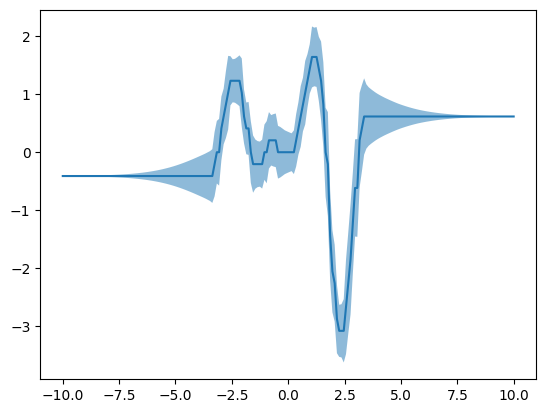

In [63]:
x_test = np.linspace(-10,10,200)
x_test = torch.from_numpy(x_test[...,None]).float()
model.eval()
with torch.no_grad():
  mu, entropy = model.forward_regress_entropy(x_test)
plt.plot(x_test, mu)
plt.fill_between(
    x_test.ravel(),
    mu.ravel() - 20*entropy.ravel(),
    mu.ravel() + 20*entropy.ravel(),
    alpha=0.5,
)
plt.show()